In [1]:
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

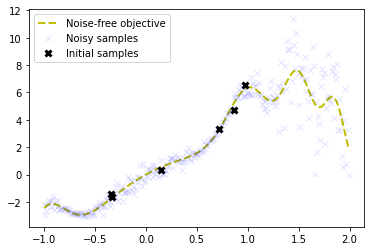

In [11]:
noise = 1

def f(X, noise=noise):
    return (-torch.sin(5*X**2) - X**4 + 0.3 *X** 3 + 2 * X **2 + 4.1*X + 
            noise * torch.randn_like(X) * (.5 - X ** 2))

def repeat(f, bounds):
    new_bounds = (bounds[0], 2 * bounds[1] - bounds[0])
    def g(X, noise=noise):
        return (X < bounds[1]) * f(X, noise) + (X >= bounds[1]) * (f(X - bounds[1] + bounds[0], noise) + 
                                                                  f(torch.FloatTensor([bounds[1]]), 0) -
                                                                   f(torch.FloatTensor([bounds[0]]), 0))
    return g, new_bounds
    

bounds = (-1, 2)
# f, bounds = repeat(f, bounds)
# f, bounds = repeat(f, bounds)

X_init = (bounds[1] - bounds[0]) * torch.rand(6, 1) + bounds[0]
Y_init = f(X_init)

X = torch.arange(bounds[0], bounds[1], 0.01).reshape(-1, 1)
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [22]:
def optimize(model_name, plot=False, n_steps=5, **kwargs):
    train_X = X_init
    train_Y = Y_init


    state_dict = None
    max_value_per_step = [train_Y.max().item()]
    for _ in range(n_steps):
        if model_name == EpistemicPredictor:

            ood_X = (bounds[1] - bounds[0]) * torch.rand(5, 1) + bounds[0]
            additional_data = {'ood_X': ood_X,
                       'ood_Y': f(ood_X),
                       'train_Y_2': f(train_X)}
            model = model_name(train_X, train_Y, additional_data, **kwargs)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            for _ in range(25):
                losses = model.fit()
                print(losses['f'])
        elif model_name == SingleTaskGP:
            model = model_name(train_X, train_Y)
            mll = ExactMarginalLogLikelihood(model.likelihood, model)
            if state_dict is not None:
                model.load_state_dict(state_dict)
            fit_gpytorch_model(mll)
        else:
            raise Exception('Not sure this would work !')

        EI = ExpectedImprovement(model, train_Y.max().item())
        eis = EI(X.unsqueeze(1)).detach()
        max_ei, argmax_ei = torch.max(eis, 0)
        xmax = X[argmax_ei].item()
        max_ei = max_ei.item()

        bounds_t = torch.FloatTensor([[bounds[0]], [bounds[1]]])
        candidate, acq_value = optimize_acqf(
            EI, bounds=bounds_t, q=1, num_restarts=5, raw_samples=50,
        )

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
            # Plot optimization objective with noise level
            ax1.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
            ax1.plot(X, f(X), 'rx', lw=1, alpha=0.2, label='Noisy samples')
            ax1.plot(train_X, train_Y, 'kx', mew=3, label='samples')
            ax1.plot(train_X, additional_data['train_Y_2'], 'gx', mew=3, label='samples')

            ax1.plot(X, model(X).mean.detach().squeeze(), label='mean pred')
            ax1.fill_between(X.numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() - model(X).stddev.detach().numpy().ravel(),
                             model(X).mean.detach().numpy().ravel() + model(X).stddev.detach().numpy().ravel(),
                             alpha=.4)

            if isinstance(model, EpistemicPredictor):
                ax1.plot(X, model.density_estimator.score_samples(X), 'r-', label='density')

            ax2.plot(X, eis, 'r-', label='EI')
            ax2.plot(X, [max_ei] * len(X), 'b--')
            ax2.plot([xmax] * 100, torch.linspace(0, max_ei, 100), 'b--')
            ax1.legend()
            ax2.legend()

            plt.show()
            
        train_X = torch.cat([train_X, candidate])
        train_Y = torch.cat([train_Y, f(candidate)])
        if model_name == EpistemicPredictor:
            additional_data['train_Y_2'] = torch.cat([additional_data['train_Y_2'], f(candidate)])
        state_dict = model.state_dict()

        max_value_per_step.append(train_Y.max().item())

    return max_value_per_step

[15.53684139251709, 10.931483268737793]
[10.352073669433594, 9.940531730651855]
[4.866266250610352, 4.644906520843506]
[0.7413479685783386, 0.6079322099685669]
[0.25875067710876465, 0.1870240718126297]
[0.10839567333459854, 0.35867154598236084]
[0.21811212599277496, 0.2019026279449463]
[0.34123340249061584, 0.17353397607803345]
[0.4054030179977417, 0.07648331671953201]
[0.173164963722229, 0.21709953248500824]
[0.10342337936162949, 0.19240979850292206]
[0.16050507128238678, 0.09491757303476334]
[0.1794726848602295, 0.13139988481998444]
[0.06867419928312302, 0.17450030148029327]
[0.11981281638145447, 0.10840007662773132]
[0.06404287368059158, 0.13577204942703247]
[0.07388628274202347, 0.07849789410829544]
[0.08249185234308243, 0.09331724047660828]
[0.10125172883272171, 0.05394164100289345]
[0.057882100343704224, 0.08233242481946945]
[0.09937587380409241, 0.05082288011908531]
[0.05920760706067085, 0.09022214263677597]
[0.06754230707883835, 0.0810842290520668]
[0.08874446153640747, 0.05218

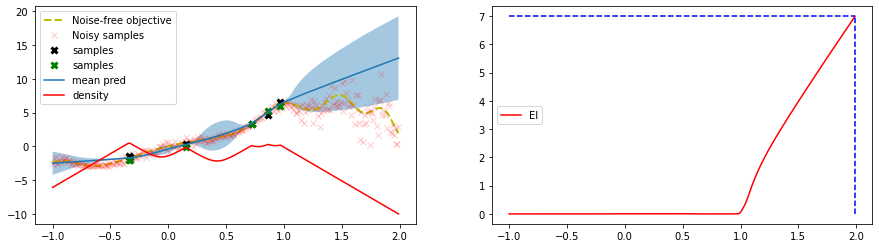

[43.793331146240234, 0.7180118560791016, 17.157407760620117]
[1.883337140083313, 4.458880424499512, 9.733585357666016]
[3.6111981868743896, 0.14747251570224762, 7.5961503982543945]
[0.21769310534000397, 1.2516727447509766, 1.8844414949417114]
[1.0203574895858765, 0.31789717078208923, 0.06141344830393791]
[0.8756964206695557, 0.14485687017440796, 0.6115526556968689]
[0.28533270955085754, 1.0627728700637817, 0.009430407546460629]
[0.13575175404548645, 0.9592990279197693, 0.10793745517730713]
[0.08813745528459549, 0.8523340225219727, 0.14732858538627625]
[0.895329475402832, 0.13954941928386688, 0.08307221531867981]
[0.1937749832868576, 0.8517008423805237, 0.030555713921785355]
[0.10156688094139099, 1.225332260131836, 0.0005693490384146571]
[0.2040719985961914, 0.9336549639701843, 0.018247408792376518]
[0.14309777319431305, 0.9967332482337952, 0.03423041105270386]
[0.14767076075077057, 0.939093828201294, 0.019167225807905197]
[0.18480026721954346, 0.08976060152053833, 2.7952051162719727]
[

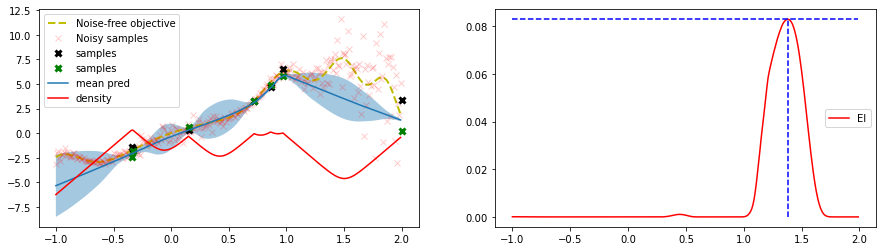

[1.7759462594985962, 0.8023325204849243]
[0.35984140634536743, 2.17008900642395]
[0.5933586955070496, 1.9215296506881714]
[1.9395933151245117, 0.3168967366218567]
[0.08960037678480148, 2.215399742126465]
[1.9893231391906738, 0.2728513777256012]
[2.1438517570495605, 0.11886904388666153]
[1.9527348279953003, 0.3459315299987793]
[0.5145822763442993, 1.8029839992523193]
[0.3349199593067169, 1.974530577659607]
[1.8492968082427979, 0.4931761622428894]
[0.2856636643409729, 1.9121674299240112]
[0.4276873767375946, 2.0173521041870117]
[0.5797412395477295, 1.7864655256271362]
[1.8993444442749023, 0.3572620153427124]
[1.870495319366455, 0.3655397295951843]
[1.9357348680496216, 0.28204166889190674]
[0.514473557472229, 1.668986439704895]
[0.4852138161659241, 1.72251296043396]
[1.8973791599273682, 0.299752801656723]
[1.6942757368087769, 0.5202935934066772]
[1.750115990638733, 0.5013188123703003]
[1.9096919298171997, 0.3373754620552063]
[0.06717284023761749, 2.109558582305908]
[0.11182407289743423, 2

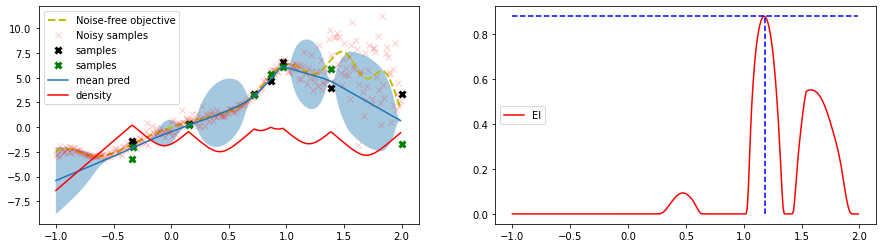

[0.12869855761528015, 3.04789662361145, 6.25777006149292]
[3.1019792556762695, 1.485533595085144, 0.10888968408107758]
[3.2277724742889404, 0.09510839730501175, 5.246394634246826]
[0.09335587173700333, 4.315032005310059, 0.3311161696910858]
[0.05606531351804733, 2.9353880882263184, 5.395982265472412]
[1.239255666732788, 0.21525026857852936, 11.742170333862305]
[4.1799702644348145, 0.09854329377412796, 0.6826189160346985]
[2.9978280067443848, 1.3921940326690674, 0.0760861188173294]
[0.34192290902137756, 2.917285442352295, 5.296494960784912]
[1.2087411880493164, 3.0051469802856445, 0.008283586241304874]
[0.05161334201693535, 1.383758306503296, 11.526939392089844]
[4.288116455078125, 0.09968394041061401, 0.060658399015665054]
[2.9448587894439697, 0.061748750507831573, 5.87622594833374]
[1.379682183265686, 3.1202895641326904, 0.0040052179247140884]
[0.20746463537216187, 4.371957778930664, 0.00878721009939909]
[3.009075880050659, 1.3256322145462036, 0.07078120112419128]
[3.231036901473999, 

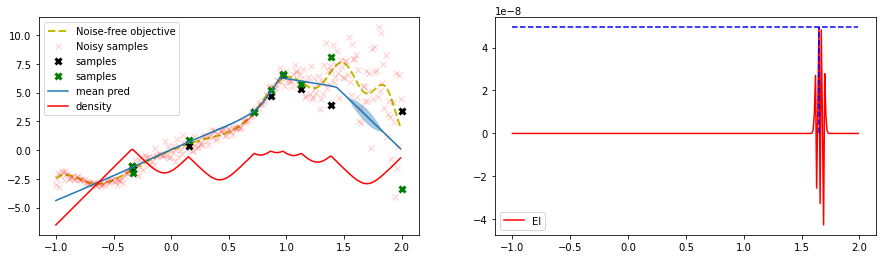

[0.5025809407234192, 7.713368892669678]
[1.7043434381484985, 5.648152828216553]
[0.7019649744033813, 3.946605682373047]
[3.417332172393799, 0.7792305946350098]
[3.2915961742401123, 0.8473641276359558]
[0.8413512110710144, 3.3915481567382812]
[0.7526528239250183, 3.374709367752075]
[0.14011426270008087, 4.068276882171631]
[0.4969688355922699, 3.6483664512634277]
[3.767176389694214, 0.543948769569397]
[3.6206600666046143, 0.5487946271896362]
[0.44662776589393616, 3.5450539588928223]
[0.4739139974117279, 3.66410756111145]
[3.2691128253936768, 1.0998622179031372]
[3.3228650093078613, 0.7801551818847656]
[3.4936814308166504, 0.4954981803894043]
[3.5695102214813232, 0.6109819412231445]
[3.4744060039520264, 0.6422969698905945]
[3.0139811038970947, 0.8059425354003906]
[3.537385940551758, 0.537987232208252]
[3.491896390914917, 0.5623974204063416]
[0.4747947156429291, 3.416804075241089]
[0.7387462258338928, 3.0295403003692627]
[3.4096226692199707, 0.40254634618759155]
[0.32492753863334656, 3.448

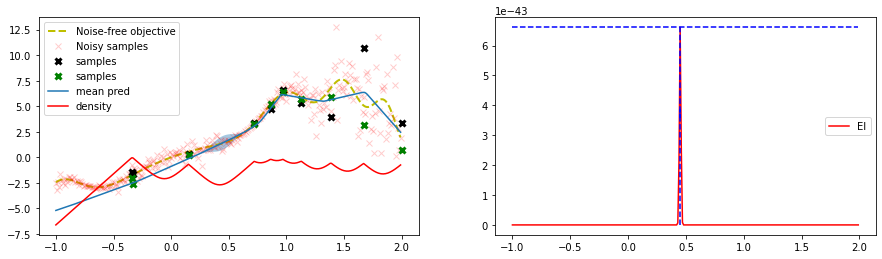

[4.265920639038086, 0.7899117469787598, 11.180415153503418]
[5.758645057678223, 0.49871835112571716, 0.39795130491256714]
[0.49532613158226013, 5.615784168243408, 0.42407238483428955]
[3.548767566680908, 2.5315957069396973, 0.5546793341636658]
[5.239741325378418, 0.5172654986381531, 0.08413690328598022]
[3.329090118408203, 2.224498987197876, 0.2618636190891266]
[0.43890246748924255, 4.7583794593811035, 0.5548381805419922]
[1.959699273109436, 2.8422672748565674, 2.2707879543304443]
[3.3358559608459473, 1.9386285543441772, 0.024713050574064255]
[2.926675796508789, 2.1155319213867188, 0.350496768951416]
[4.610147953033447, 0.23594315350055695, 2.185253858566284]
[2.4379894733428955, 2.8680195808410645, 0.027269897982478142]
[2.196798086166382, 0.10588270425796509, 13.430912017822266]
[2.8264577388763428, 2.2133851051330566, 0.057921502739191055]
[0.1578088104724884, 4.7123870849609375, 0.23617945611476898]
[0.14470751583576202, 4.7461838722229, 0.5695604085922241]
[0.5556291341781616, 2.7

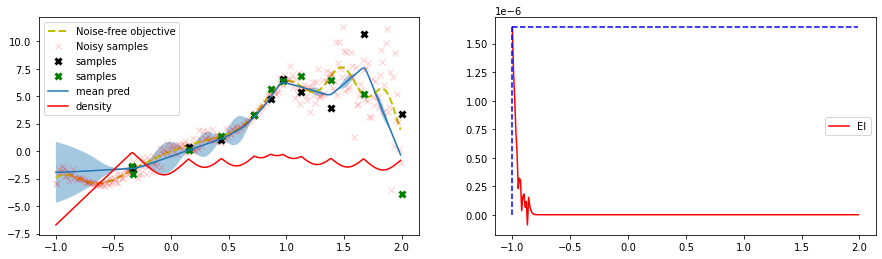

[3.9897825717926025, 0.2851913869380951]
[1.9720406532287598, 2.011223793029785]
[2.0004584789276123, 1.5688214302062988]
[3.3885533809661865, 0.1452372819185257]
[2.703204870223999, 0.8074483871459961]
[1.5111409425735474, 2.0126407146453857]
[1.9943971633911133, 1.4882102012634277]
[3.339033842086792, 0.19482098519802094]
[0.9428572654724121, 2.5682098865509033]
[0.10496781021356583, 3.354844093322754]
[0.943303108215332, 2.52258038520813]
[1.5025664567947388, 2.0441229343414307]
[1.947461724281311, 1.5593823194503784]
[1.4949232339859009, 1.9962478876113892]
[0.16061724722385406, 3.3496792316436768]
[2.7732696533203125, 0.6761298179626465]
[1.6547274589538574, 1.9275660514831543]
[2.537895917892456, 0.9366586804389954]
[1.1326357126235962, 2.555835485458374]
[0.09884234517812729, 3.42611026763916]
[0.7398467659950256, 2.8723182678222656]
[3.3470299243927, 0.2529040277004242]
[0.7405940890312195, 2.7895119190216064]
[1.5952519178390503, 1.9155734777450562]
[0.9538176655769348, 2.5808

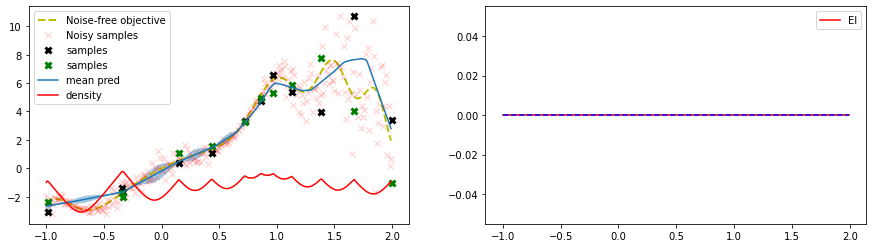

[1.9032649993896484, 0.610187828540802, 0.2880725562572479]
[0.5173110365867615, 1.2385255098342896, 3.1654672622680664]
[1.1925526857376099, 1.048547625541687, 0.3494832515716553]
[1.1441045999526978, 1.0588144063949585, 0.263542115688324]
[0.7056983113288879, 1.4512377977371216, 0.2542923092842102]
[1.076870083808899, 0.9172546863555908, 0.2989410161972046]
[1.1114295721054077, 0.8930317759513855, 0.274996817111969]
[1.5261645317077637, 0.3282558023929596, 0.574722409248352]
[1.786547303199768, 0.6880106925964355, 0.009043173864483833]
[0.15238839387893677, 1.3871272802352905, 2.6979188919067383]
[0.9259459376335144, 1.070538878440857, 0.025517383590340614]
[0.5500401258468628, 1.4480714797973633, 0.5750958323478699]
[2.0616304874420166, 0.644292414188385, 0.2839987576007843]
[1.1176954507827759, 0.7925274968147278, 0.27943018078804016]
[1.369533896446228, 0.9207904934883118, 0.016085756942629814]
[0.22789208590984344, 2.046704053878784, 0.007450931705534458]
[0.9695084095001221, 1.5

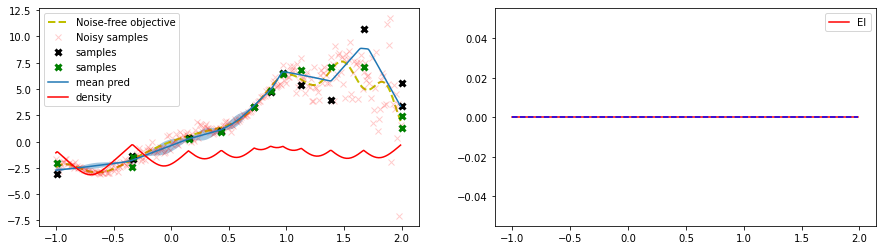

[2.283733367919922, 0.238997220993042]
[1.4629565477371216, 0.7397938966751099]
[0.27493423223495483, 1.8451164960861206]
[0.981113612651825, 1.2277958393096924]
[0.9786260724067688, 1.1527780294418335]
[1.1666104793548584, 0.9432563185691833]
[1.1046082973480225, 1.0575125217437744]
[1.0818891525268555, 1.0072344541549683]
[1.7061642408370972, 0.42721566557884216]
[0.9078055620193481, 1.231350302696228]
[1.7098579406738281, 0.3772002160549164]
[2.086519956588745, 0.13385458290576935]
[2.0737245082855225, 0.09140557795763016]
[0.08431779593229294, 2.145001173019409]
[1.221474289894104, 1.4177448749542236]
[0.7743202447891235, 1.356531023979187]
[0.30730441212654114, 1.7687565088272095]
[0.8217312097549438, 1.2787535190582275]
[0.16408611834049225, 2.1967384815216064]
[1.7063732147216797, 0.4384106695652008]
[1.962533950805664, 0.37327656149864197]
[1.8675416707992554, 0.39244821667671204]
[0.7778058648109436, 1.6970871686935425]
[0.4442259669303894, 2.1004602909088135]
[0.3065457642078

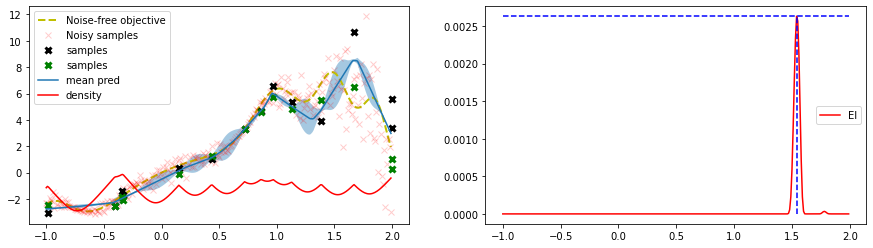

[1.171288251876831, 2.888784885406494, 2.4096992015838623]
[4.003578186035156, 0.272296279668808, 0.17807333171367645]
[3.801178216934204, 0.6361476182937622, 0.16885477304458618]
[3.6616456508636475, 0.22072508931159973, 3.2331442832946777]
[1.5853596925735474, 2.6353976726531982, 0.8208747506141663]
[1.1289058923721313, 3.219817638397217, 0.18651308119297028]
[0.5433487296104431, 1.6461799144744873, 17.103574752807617]
[0.9818500876426697, 3.3469417095184326, 0.00021708421991206706]
[0.34010013937950134, 2.8039565086364746, 5.295465469360352]
[0.7664770483970642, 3.478975296020508, 0.20052677392959595]
[1.1578933000564575, 2.4489643573760986, 4.763442039489746]
[0.44303402304649353, 3.7983593940734863, 3.705298900604248]
[0.44340524077415466, 4.0809197425842285, 0.12777170538902283]
[0.6997585892677307, 3.264050006866455, 0.1066182479262352]
[3.517984390258789, 0.3546590209007263, 0.01259759534150362]
[3.2198922634124756, 0.9081013798713684, 0.14808890223503113]
[3.202385663986206, 0

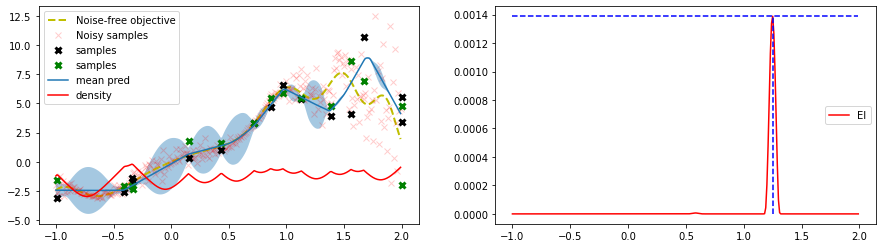

[1.7300995588302612, 0.71629399061203]
[0.5805990695953369, 1.6520944833755493]
[0.2598332166671753, 1.8576436042785645]
[1.4682669639587402, 0.6463332772254944]
[1.5131560564041138, 0.5048280358314514]
[0.2400730699300766, 1.7396777868270874]
[1.7768090963363647, 0.21723759174346924]
[1.8800724744796753, 0.08969638496637344]
[1.3912508487701416, 0.6361271142959595]
[1.88118577003479, 0.11332621425390244]
[1.8997997045516968, 0.07685678452253342]
[1.416829228401184, 0.5612595677375793]
[1.7522640228271484, 0.22361278533935547]
[1.4294195175170898, 0.5559301376342773]
[0.08435346931219101, 1.883115530014038]
[1.3659921884536743, 0.5884081125259399]
[1.9425512552261353, 0.06448088586330414]
[0.44983455538749695, 1.4811443090438843]
[0.15733420848846436, 1.7479432821273804]
[0.23158462345600128, 1.7805505990982056]
[0.4528466463088989, 1.4883023500442505]
[0.07137502729892731, 1.9116369485855103]
[1.8249746561050415, 0.20301567018032074]
[0.20240609347820282, 1.7412055730819702]
[1.363721

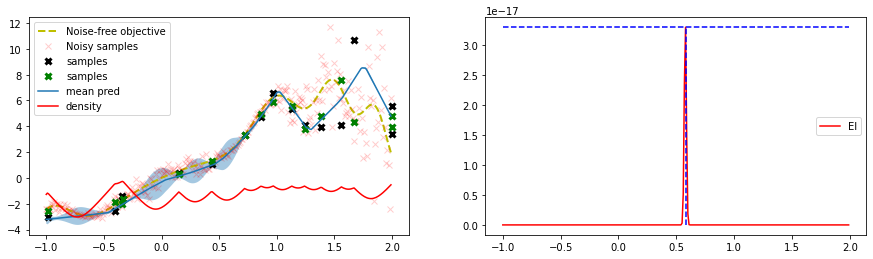

[3.3514580726623535, 1.8548803329467773, 0.106657475233078]
[2.5179920196533203, 1.767317295074463, 0.1366271674633026]
[2.710393190383911, 1.403615951538086, 0.8395984172821045]
[0.5530659556388855, 3.6343746185302734, 0.012644234113395214]
[2.2695531845092773, 1.8570716381072998, 0.7036688327789307]
[1.9016797542572021, 2.24169921875, 0.026591649278998375]
[1.5608195066452026, 2.7907252311706543, 0.7639845013618469]
[2.054290771484375, 2.1897006034851074, 0.013554880395531654]
[1.7304575443267822, 2.3324739933013916, 0.6203714609146118]
[1.5453718900680542, 2.690647602081299, 0.08702964335680008]
[3.7434239387512207, 0.4945923686027527, 0.0034802304580807686]
[2.306600332260132, 1.8386398553848267, 0.12019383907318115]
[2.5782644748687744, 1.5988037586212158, 0.10756224393844604]
[1.2945356369018555, 2.809849739074707, 0.6098206043243408]
[3.922529935836792, 0.28577950596809387, 0.07858065515756607]
[2.6793813705444336, 1.5981745719909668, 0.6251580715179443]
[2.429623603820801, 1.67

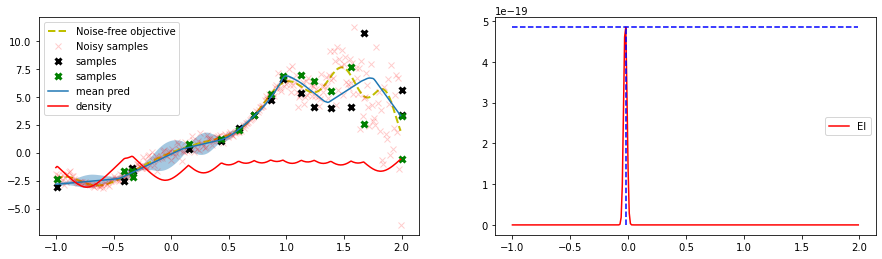

[2.4544870853424072, 2.216305732727051]
[1.182542324066162, 3.1784820556640625]
[3.1448144912719727, 0.9149521589279175]
[2.4553256034851074, 1.5623736381530762]
[1.79633629322052, 2.2158584594726562]
[3.579396963119507, 0.4186273217201233]
[1.5788553953170776, 2.403188705444336]
[0.347018837928772, 3.6460118293762207]
[1.8304129838943481, 2.148347854614258]
[1.8462159633636475, 2.1559696197509766]
[1.6294044256210327, 2.373717784881592]
[3.628295421600342, 0.3839930295944214]
[3.75457763671875, 0.25217461585998535]
[1.0175460577011108, 2.9435231685638428]
[1.6477181911468506, 2.332846164703369]
[2.5345089435577393, 1.5352435111999512]
[3.3124780654907227, 0.6919748783111572]
[1.914847731590271, 2.14727520942688]
[3.59842848777771, 0.45397859811782837]
[2.4392805099487305, 1.5555384159088135]
[0.7811315059661865, 3.1637449264526367]
[0.932887077331543, 3.1269421577453613]
[2.125068426132202, 1.8954535722732544]
[3.289182662963867, 0.7637625932693481]
[3.5697855949401855, 0.408967822790

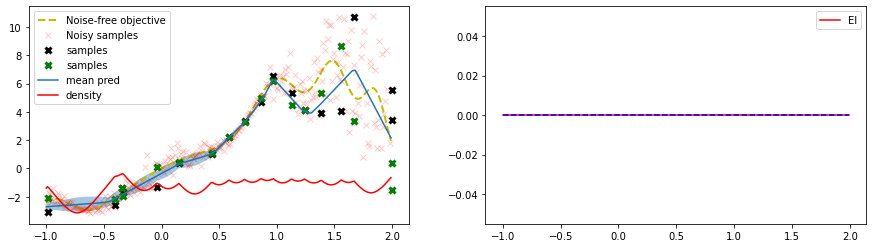

[0.6721324920654297, 3.145500659942627, 13.787107467651367]
[2.4180474281311035, 1.937267780303955, 0.6311096549034119]
[1.5493673086166382, 2.373624086380005, 0.4575488567352295]
[2.321218729019165, 1.7750422954559326, 0.2161071002483368]
[0.8636595010757446, 3.0782177448272705, 0.355597585439682]
[2.2947115898132324, 1.7268414497375488, 0.08346502482891083]
[2.5815765857696533, 1.395336389541626, 0.0007831468246877193]
[3.15242600440979, 0.8109400272369385, 0.001401035115122795]
[2.6315038204193115, 1.3449379205703735, 0.1865704208612442]
[3.1504018306732178, 0.5173356533050537, 3.939310073852539]
[2.2310876846313477, 1.8037457466125488, 0.32870346307754517]
[0.7829940319061279, 3.2316367626190186, 0.004079988691955805]
[1.7531770467758179, 2.271285057067871, 0.007505882065743208]
[1.3965519666671753, 2.4478044509887695, 0.002773905638605356]
[1.5583420991897583, 1.2292709350585938, 11.168225288391113]
[3.4512076377868652, 0.5832393169403076, 0.07034255564212799]
[3.701643228530884, 

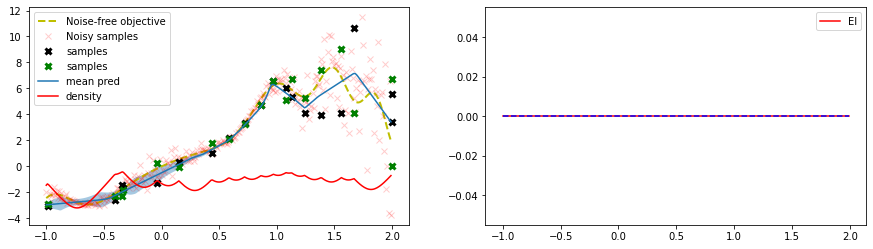

[2.7322545051574707, 0.593719482421875]
[2.5765132904052734, 0.5897704362869263]
[2.226027250289917, 0.8077910542488098]
[0.2269539088010788, 2.6957285404205322]
[2.443727970123291, 0.4616086483001709]
[2.3934671878814697, 0.551200807094574]
[1.8406881093978882, 1.0348780155181885]
[2.356184244155884, 0.5429241061210632]
[2.126643419265747, 0.760281503200531]
[2.0899434089660645, 0.8008627891540527]
[2.0904271602630615, 0.7451686859130859]
[0.5478086471557617, 2.180821657180786]
[0.8420774340629578, 2.1148428916931152]
[0.7539044618606567, 2.201931953430176]
[2.3392348289489746, 0.5042605400085449]
[0.23831629753112793, 2.655991554260254]
[2.241549491882324, 0.6921411156654358]
[2.231118679046631, 0.9632307291030884]
[2.706382989883423, 0.16127172112464905]
[2.0054163932800293, 0.8678808212280273]
[0.7866202592849731, 2.0194480419158936]
[2.2459959983825684, 0.463728666305542]
[1.8207066059112549, 1.025956630706787]
[0.4317195415496826, 2.432539463043213]
[0.34740886092185974, 2.445715

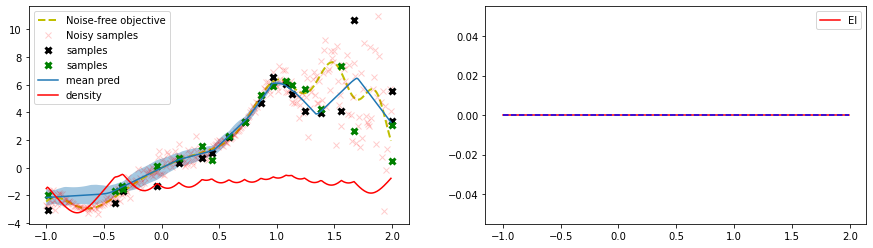

[0.8593036532402039, 2.598576307296753, 0.011233843863010406]
[0.2094738781452179, 1.9111299514770508, 11.5271577835083]
[1.7126500606536865, 1.7053645849227905, 0.2022201120853424]
[2.5859010219573975, 0.5288585424423218, 0.21538488566875458]
[0.15374411642551422, 2.5094847679138184, 4.599501609802246]
[1.701189398765564, 1.4317330121994019, 0.08060985058546066]
[1.7494251728057861, 1.1048227548599243, 2.773898124694824]
[1.510953426361084, 1.4771873950958252, 0.09964732080698013]
[1.7926374673843384, 1.3263530731201172, 0.033086106181144714]
[1.5400876998901367, 0.39642852544784546, 11.417572021484375]
[0.415123850107193, 2.7012250423431396, 0.04925788938999176]
[0.7259342074394226, 2.417128324508667, 0.11505740880966187]
[0.729865550994873, 2.420830488204956, 0.0045960815623402596]
[2.4771974086761475, 0.5301395058631897, 0.1794310063123703]
[1.8733081817626953, 1.3235833644866943, 0.11960981041193008]
[1.9149408340454102, 0.14962726831436157, 10.27076530456543]
[0.27481013536453247

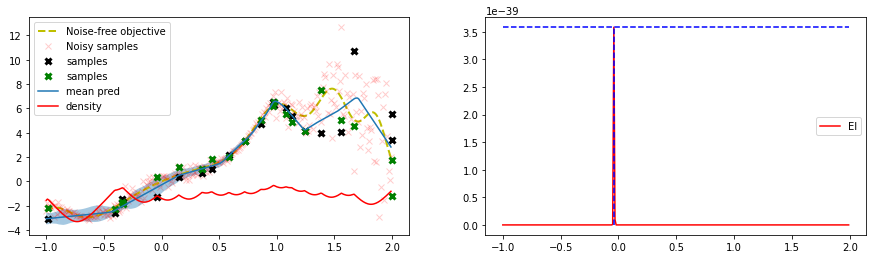

[1.930208683013916, 1.005508303642273]
[2.1905906200408936, 0.5553253889083862]
[1.3435145616531372, 1.2966628074645996]
[0.9858950972557068, 1.547264814376831]
[1.38235342502594, 1.1752103567123413]
[0.8818190097808838, 1.6442856788635254]
[1.3426852226257324, 1.0474162101745605]
[0.2409869283437729, 2.1482484340667725]
[2.1137278079986572, 0.25677940249443054]
[1.4852370023727417, 0.8233974575996399]
[2.1440789699554443, 0.2166903167963028]
[1.4654444456100464, 0.8908177018165588]
[1.500392198562622, 0.6870604157447815]
[0.7747640609741211, 1.509408950805664]
[0.5712789297103882, 1.7384707927703857]
[0.6866710782051086, 1.5587024688720703]
[0.36405935883522034, 1.8830790519714355]
[1.1685608625411987, 0.9754464626312256]
[1.5707135200500488, 0.6035576462745667]
[0.6667206883430481, 1.4678212404251099]
[1.0038856267929077, 1.0896140336990356]
[0.9472477436065674, 1.2335530519485474]
[0.14621731638908386, 1.8862015008926392]
[0.6234336495399475, 1.4247609376907349]
[0.3696243464946747,

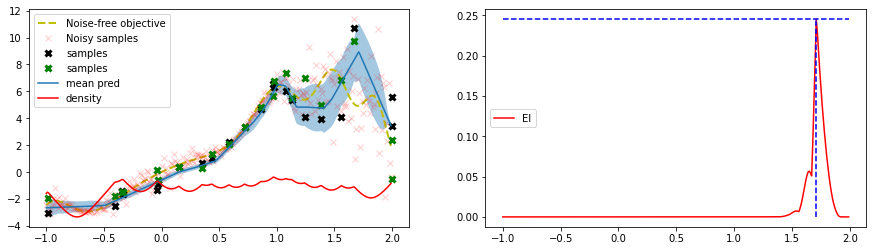

[5.1589813232421875, 1.1090271472930908, 19.62305450439453]
[3.2822256088256836, 3.8001723289489746, 0.44998788833618164]
[5.015402317047119, 0.9949977993965149, 0.10869724303483963]
[0.16909748315811157, 5.649498462677002, 0.46152156591415405]
[1.8416399955749512, 3.1557912826538086, 6.974549293518066]
[5.333967208862305, 0.848872184753418, 0.3391943871974945]
[0.4140123426914215, 5.449522018432617, 0.014464296400547028]
[0.7440510392189026, 5.075158596038818, 0.009187223389744759]
[4.9374165534973145, 0.8880285620689392, 0.08061393350362778]
[4.7764201164245605, 0.9160999059677124, 0.35049864649772644]
[3.8119306564331055, 1.9060763120651245, 0.6960765719413757]
[4.790170192718506, 1.2544702291488647, 0.2526775002479553]
[1.9897500276565552, 3.976435661315918, 0.13380514085292816]
[4.4562602043151855, 1.1618516445159912, 0.24696974456310272]
[1.4166289567947388, 4.240544319152832, 0.8111643195152283]
[1.4800158739089966, 4.361539840698242, 0.24053935706615448]
[1.2058743238449097, 4.

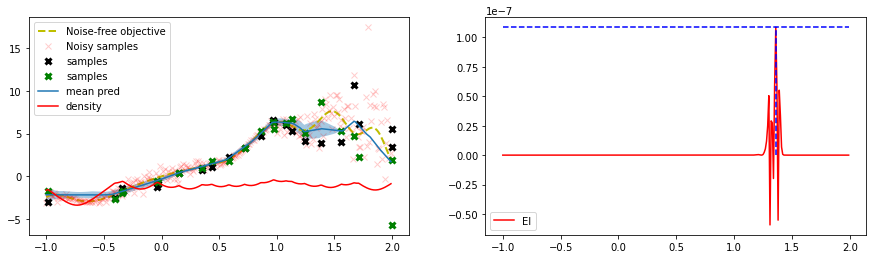

[1.5028146505355835, 3.8619110584259033]
[0.6378970742225647, 3.3356425762176514]
[2.012530565261841, 1.406997799873352]
[1.4355977773666382, 2.069852113723755]
[2.018657922744751, 1.3839417695999146]
[2.04258131980896, 1.2640613317489624]
[1.0566718578338623, 2.2378315925598145]
[1.4715336561203003, 1.8027805089950562]
[1.5204544067382812, 1.8504377603530884]
[2.014310598373413, 1.2458595037460327]
[2.0712766647338867, 1.2846765518188477]
[2.1525003910064697, 1.168297529220581]
[2.372997760772705, 0.8710129857063293]
[1.8739107847213745, 1.3656100034713745]
[2.0867702960968018, 1.2492092847824097]
[1.6775156259536743, 1.541473388671875]
[2.515012741088867, 0.7755255699157715]
[1.487107276916504, 1.8203701972961426]
[1.5144147872924805, 1.7149676084518433]
[0.745124340057373, 2.6960322856903076]
[1.8917330503463745, 1.3748122453689575]
[1.5861190557479858, 1.77983558177948]
[1.542044997215271, 1.7428950071334839]
[1.4901326894760132, 1.7454252243041992]
[0.9859814643859863, 2.404663562

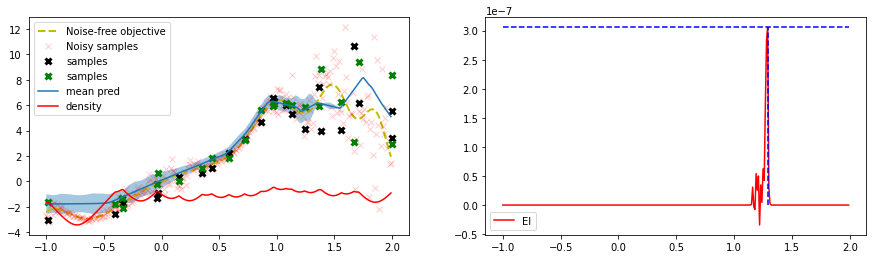

[1.7410660982131958, 4.604011058807373, 14.943946838378906]
[1.8234671354293823, 3.57785701751709, 0.10076870024204254]
[0.45838308334350586, 4.119333267211914, 3.3085813522338867]
[1.261025071144104, 1.6713863611221313, 26.121334075927734]
[1.9252229928970337, 2.8994076251983643, 0.099607452750206]
[2.321014404296875, 2.508263349533081, 0.01771392859518528]
[3.988314628601074, 0.5033314824104309, 3.156392812728882]
[2.001807928085327, 2.7155723571777344, 0.5696409344673157]
[1.8227308988571167, 2.7205331325531006, 2.2273478507995605]
[1.7767246961593628, 0.983147382736206, 25.09244155883789]
[4.12091588973999, 0.6734819412231445, 0.05662700906395912]
[0.623290479183197, 4.139492511749268, 0.11995095014572144]
[0.41453227400779724, 4.275218963623047, 0.21911711990833282]
[3.6222469806671143, 1.0593496561050415, 0.021582556888461113]
[3.803483247756958, 0.8578572869300842, 0.24818149209022522]
[0.47492051124572754, 4.129663944244385, 0.5245596170425415]
[2.8778603076934814, 1.6328344345

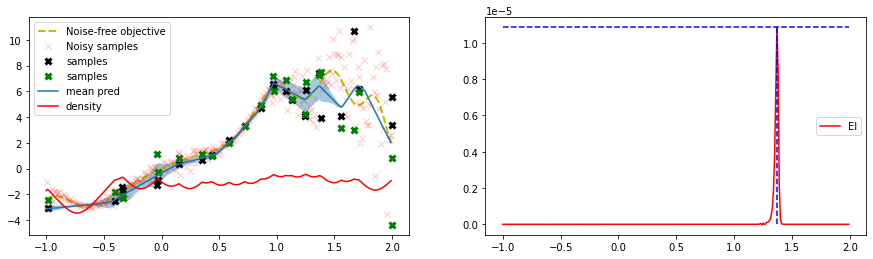

[6.560872554779053,
 6.560872554779053,
 6.560872554779053,
 6.560872554779053,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883,
 10.688783645629883]

In [23]:
density_estimator = FixedKernelDensityEstimator('exponential', 0.1)
networks = {'a_predictor': create_network(1, 1, 128, 'tanh', True),
            'e_predictor': create_network(2, 1, 128, 'relu', True),
            'f_predictor': create_network(1, 1, 128, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }


optimize(EpistemicPredictor, plot=True, n_steps=20, networks=networks, optimizers=optimizers, density_estimator=density_estimator)
# optimize(SingleTaskGP, plot=True, n_steps=20)

In [5]:
import numpy as np
n_runs = 5
n_steps = 25
gp_runs = np.zeros((n_runs, n_steps + 1))
ep_runs = np.zeros((n_runs, n_steps + 1))

for i in range(n_runs):
    print(f"Run {i+1}/{n_runs}")
    gp_runs[i] = optimize(SingleTaskGP, plot=False, n_steps=n_steps)
    density_estimator = FixedKernelDensityEstimator('exponential', 0.1)
    networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
                'e_predictor': create_network(2, 1, 64, 'relu', True),
                'f_predictor': create_network(1, 1, 64, 'relu', False)
                }

    optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-3),
                  'e_optimizer': create_optimizer(networks['e_predictor'], 1e-4),
                  'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
                  }
    ep_runs[i] = optimize(EpistemicPredictor, plot=False, n_steps=n_steps, networks=networks, optimizers=optimizers, density_estimator=density_estimator)

Run 1/5
Run 2/5
error, adding 1e-6 to variances
error, adding 1e-6 to variances
Run 3/5
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e-6 to variances
error, adding 1e

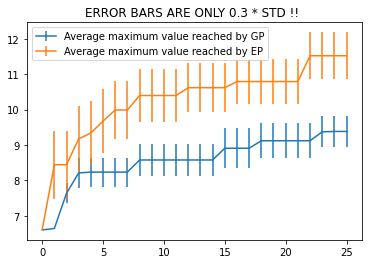

In [6]:
plt.errorbar(range(1 + n_steps), gp_runs.mean(0), .3 * gp_runs.std(0), label='Average maximum value reached by GP')
plt.errorbar(range(1 + n_steps), ep_runs.mean(0), .3 * ep_runs.std(0), label='Average maximum value reached by EP')
plt.legend()
plt.title('ERROR BARS ARE ONLY 0.3 * STD !! ')
plt.show()